In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats
import numpy as np

from lmfit import minimize, Parameters, report_fit

In [2]:
from IPython.display import Image

In [3]:
def calculate_ddG(Kd, Kd_ref, R=1.9872036e-3, T=295):
    return R*T*np.log(Kd/Kd_ref)

# GR binding curves

### Load in oligo names and sequences

In [4]:
plate1 = pd.read_excel('GROligoPlate_v2.6_Plate1.xlsx')
plate2 = pd.read_excel('GROligoPlate_v2.6_Plate2.xlsx', skipfooter=2)

oligo_df = pd.concat([plate1, plate2])
oligo_df = oligo_df.reset_index().rename(columns={'index':'Oligo', 'Concatenated':'Sequence'})

### Calibration curve

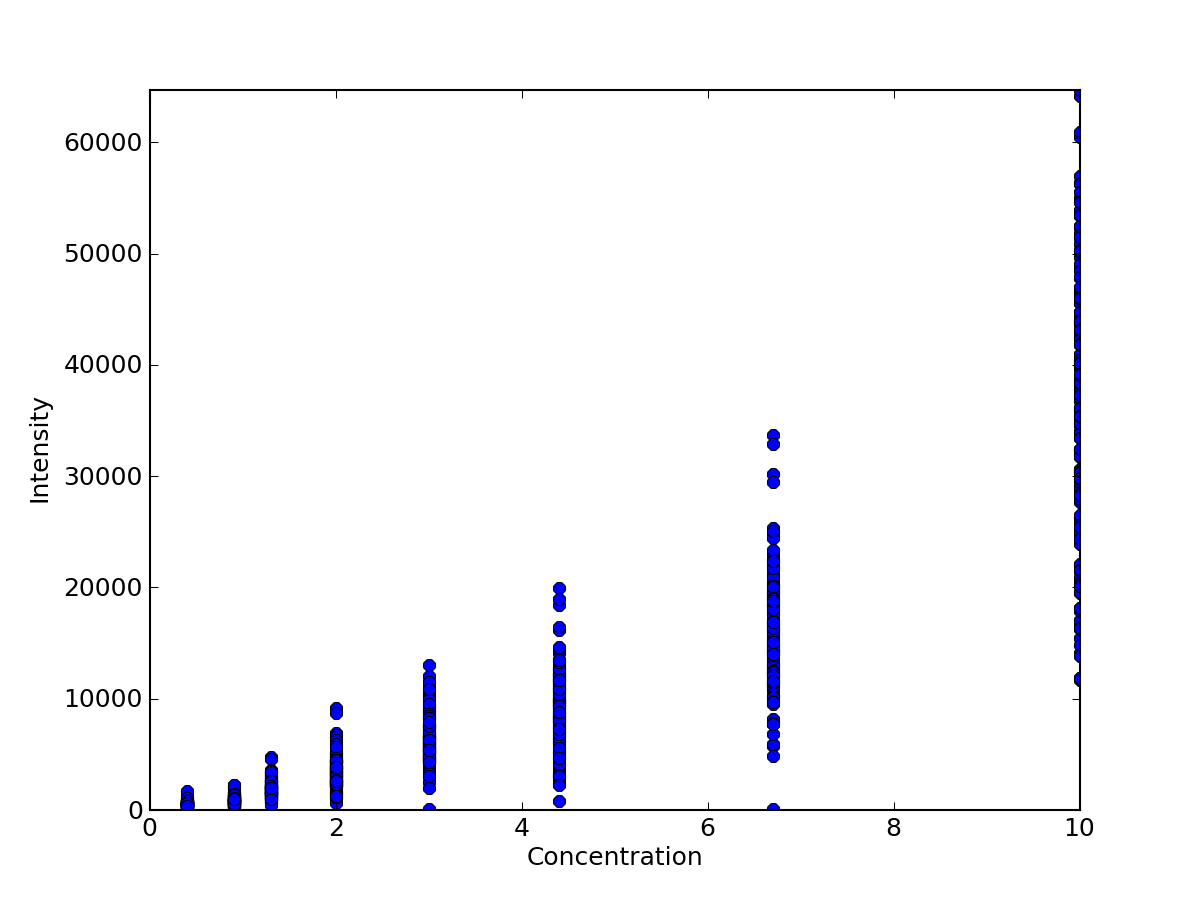

In [5]:
concentrations = [10, 6.7, 4.4, 3, 2, 1.3, 0.9, 0.4]

# load in calibration curve from August 2012
Image(filename='IntVsConc.png', width=400)

hmm okay I can't find the raw data for this calibration curve. Rather than try to pick out points and fit it, I'm just going to use DNA intensity values. This will prevent us from getting quantitative Kd values but we can still get accurate ddG estimates

### Load in GR binding curve data

In [6]:
GR_WT_1_df = pd.read_csv('../BindingCurves/GR_WT_BindingCurves/GR_Concat_Processed.txt', delimiter='\t', index_col=False)
GR_WT_2_df = pd.read_csv('../BindingCurves/GR_WT_BindingCurves_2/GR_Concat_Processed.txt', delimiter='\t', index_col=False)
GR_Dim_df = pd.read_csv('../BindingCurves/GR_Dim_BindingCurves/GRDim_Concat_Processed.txt', delimiter='\t', index_col=False)

### Perform quality control for each of these 9 datasets

In [7]:
def qc_data(df):
    temp = df.copy()
    temp = temp[temp['Oligo']!=0] #remove chambers without an oligo
    temp = temp[temp['dButton']>0] #remove chambers without an oligo
    temp = temp[temp['pButton']>0] #remove chambers without an oligo
    temp = temp[temp['dChamber']>0] #remove chambers without an oligo

    return temp

In [8]:
# perform some standard QC to get rid of bad chambers
GR_WT_1_df = qc_data(GR_WT_1_df)
GR_WT_2_df = qc_data(GR_WT_2_df)
GR_Dim_df = qc_data(GR_Dim_df)

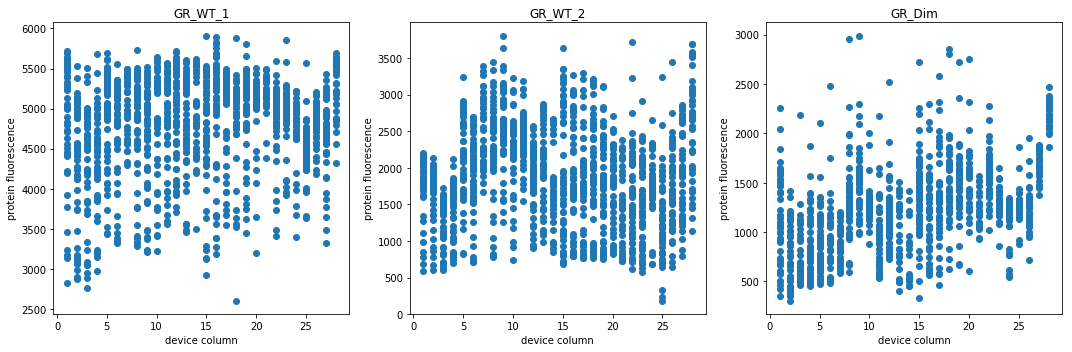

In [9]:
fig = plt.figure(figsize=(15,5))

ax = fig.add_subplot(131)
ax.scatter(GR_WT_1_df['Col'],GR_WT_1_df['pButton'])
ax.set_ylabel('protein fluorescence')
ax.set_xlabel('device column')
ax.set_title('GR_WT_1')

ax = fig.add_subplot(132)
ax.scatter(GR_WT_2_df['Col'],GR_WT_2_df['pButton'])
ax.set_ylabel('protein fluorescence')
ax.set_xlabel('device column')
ax.set_title('GR_WT_2')

ax = fig.add_subplot(133)
ax.scatter(GR_Dim_df['Col'],GR_Dim_df['pButton'])
ax.set_ylabel('protein fluorescence')
ax.set_xlabel('device column')
ax.set_title('GR_Dim')
    
fig.tight_layout()

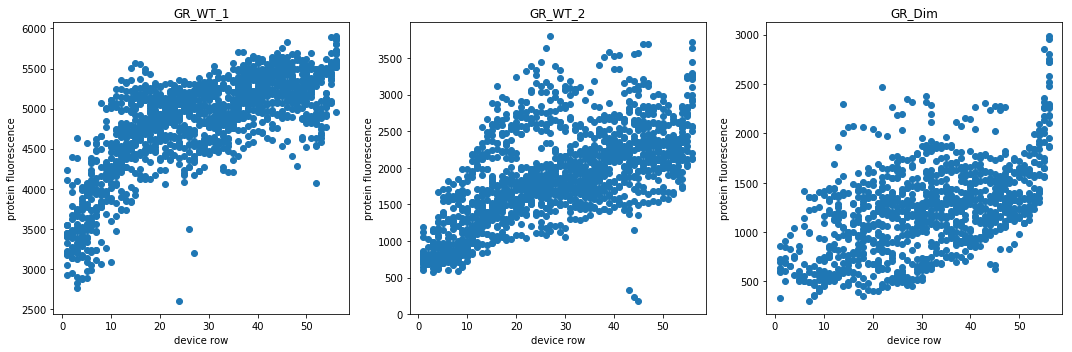

In [10]:
fig = plt.figure(figsize=(15,5))

ax = fig.add_subplot(131)
ax.scatter(GR_WT_1_df['Row'],GR_WT_1_df['pButton'])
ax.set_ylabel('protein fluorescence')
ax.set_xlabel('device row')
ax.set_title('GR_WT_1')

ax = fig.add_subplot(132)
ax.scatter(GR_WT_2_df['Row'],GR_WT_2_df['pButton'])
ax.set_ylabel('protein fluorescence')
ax.set_xlabel('device row')
ax.set_title('GR_WT_2')

ax = fig.add_subplot(133)
ax.scatter(GR_Dim_df['Row'],GR_Dim_df['pButton'])
ax.set_ylabel('protein fluorescence')
ax.set_xlabel('device row')
ax.set_title('GR_Dim')
    
fig.tight_layout()

In [11]:
#remove some outliers and problematic columns

GR_WT_1_df = GR_WT_1_df[GR_WT_1_df['Row']<54]

GR_WT_2_df = GR_WT_2_df[GR_WT_2_df['Row']<54]
GR_WT_2_df = GR_WT_2_df[GR_WT_2_df['pButton']>500]

GR_Dim_df = GR_Dim_df[GR_Dim_df['Row']<53]
GR_Dim_df = GR_Dim_df[GR_Dim_df['Col']<27]

We could maybe exclude the first 10 rows of GR_WT_1 but we have such little data that I'm not inclined to do that at the moment.

### Set up functions for global fit

In [12]:
# objective function calculates residuals of fits
def objective(params, oligo_list, ratio, chamber):
    resid = np.zeros(ratio.shape)
    # make residual per data set
    for i in oligo_list:
        resid[i-1, :] = ratio[i-1, :] - isotherm_dataset(params, i, chamber[i-1,:])
    # now flatten this to a 1D array, as minimize() needs
    return resid.flatten()

In [18]:
# function to calculate for fit
def isotherm(x,ymax,Kd):
    y = [ymax*DNA/(DNA+Kd) for DNA in x]
    return y

def isotherm_dataset(params, i, x):
    """calc isotherm from params for data set i
    using simple, hardwired naming convention"""
    Kd = params['Kd_%i' % i].value
    ymax = params['ymax_%i' % i].value
    return isotherm(x, ymax, Kd)

### Global fit for GR WT 1

In [19]:
# wrangle data into the correct format.
max_len = 8

oligo_list = list(set(GR_WT_1_df['Oligo']))
GR_WT_1_ratio = np.zeros((len(oligo_list), max_len))
GR_WT_1_chamber = np.zeros((len(oligo_list), max_len))

for i in oligo_list:
    ratios = list(GR_WT_1_df[GR_WT_1_df['Oligo']==i]['Ratio'])
    GR_WT_1_ratio[i-1,:len(ratios)] = ratios
    chambers = list(GR_WT_1_df[GR_WT_1_df['Oligo']==i]['dChamber'])
    GR_WT_1_chamber[i-1,:len(chambers)] = chambers


In [20]:
fit_params = Parameters()

for i in GR_WT_1_df['Oligo'].unique():
    fit_params.add( 'Kd_%i' % i, value=1e4, min=10.0,  max=1e10)
    fit_params.add( 'ymax_%i' % i, value=1, min=0.1,  max=10)

# but now constrain all values of ymax to have the same value
# by assigning ymax_2, ymax_3, ... ymax_n to be equal to ymax_1
for i in GR_WT_1_df['Oligo'].unique():
    if i==1:
        continue
    fit_params['ymax_%i' % i].expr='ymax_1'
    
result_global = minimize(objective, fit_params, args=(oligo_list, GR_WT_1_ratio, GR_WT_1_chamber))
# # report_fit(result.params)

Kd_global_fits = []
for i in oligo_list:
    Kd_global_fits.append(result_global.params['Kd_%i' % i].value)
    
ymax_global = result_global.params['ymax_1'].value

In [21]:
GR_WT_1_fits = pd.DataFrame({'Oligo':1+np.arange(190), 'Kd_estimate': Kd_global_fits})
Kd_ref = np.min(GR_WT_1_fits['Kd_estimate'])
GR_WT_1_fits['ddG'] = GR_WT_1_fits['Kd_estimate'].apply(lambda x: calculate_ddG(x, Kd_ref))

In [22]:
GR_WT_1_fits = GR_WT_1_fits.merge(oligo_df.drop(columns=['Well']))
GR_WT_1_fits.to_csv('GR_bindingcurves_WT_1_out.csv',index=False)

### Global fit for GR WT 2

In [23]:
# wrangle data into the correct format.
max_len = 0
for i in oligo_list:
    ratios = list(GR_WT_2_df[GR_WT_2_df['Oligo']==i]['Ratio'])
    max_len = np.max([max_len, len(ratios)])

oligo_list = list(set(GR_WT_2_df['Oligo']))
GR_WT_2_ratio = np.zeros((len(oligo_list), max_len))
GR_WT_2_chamber = np.zeros((len(oligo_list), max_len))

for i in oligo_list:
    ratios = list(GR_WT_2_df[GR_WT_2_df['Oligo']==i]['Ratio'])
    GR_WT_2_ratio[i-1,:len(ratios)] = ratios
    chambers = list(GR_WT_2_df[GR_WT_2_df['Oligo']==i]['dChamber'])
    GR_WT_2_chamber[i-1,:len(chambers)] = chambers

In [24]:
fit_params = Parameters()

for i in GR_WT_2_df['Oligo'].unique():
    fit_params.add( 'Kd_%i' % i, value=1e4, min=10.0,  max=1e10)
    fit_params.add( 'ymax_%i' % i, value=1, min=0.1,  max=10)

# but now constrain all values of ymax to have the same value
# by assigning ymax_2, ymax_3, ... ymax_n to be equal to ymax_1
for i in GR_WT_2_df['Oligo'].unique():
    if i==1:
        continue
    fit_params['ymax_%i' % i].expr='ymax_1'
    
result_global = minimize(objective, fit_params, args=(oligo_list, GR_WT_2_ratio, GR_WT_2_chamber))
# # report_fit(result.params)

Kd_global_fits = []
for i in oligo_list:
    Kd_global_fits.append(result_global.params['Kd_%i' % i].value)
    
ymax_global = result_global.params['ymax_1'].value

In [25]:
GR_WT_2_fits = pd.DataFrame({'Oligo':1+np.arange(190), 'Kd_estimate': Kd_global_fits})
Kd_ref = np.min(GR_WT_2_fits['Kd_estimate'])
GR_WT_2_fits['ddG'] = GR_WT_2_fits['Kd_estimate'].apply(lambda x: calculate_ddG(x, Kd_ref))

In [26]:
GR_WT_2_fits = GR_WT_2_fits.merge(oligo_df.drop(columns=['Well']))
GR_WT_2_fits.to_csv('GR_bindingcurves_WT_2_out.csv',index=False)

### Global fit for GR Dim

In [27]:
# wrangle data into the correct format.
max_len = 0
for i in oligo_list:
    ratios = list(GR_Dim_df[GR_Dim_df['Oligo']==i]['Ratio'])
    max_len = np.max([max_len, len(ratios)])

# oligo_list = list(set(GR_Dim_df['Oligo']))
GR_Dim_ratio = np.zeros((len(oligo_list), max_len))
GR_Dim_chamber = np.zeros((len(oligo_list), max_len))

for i in oligo_list:
    ratios = list(GR_Dim_df[GR_Dim_df['Oligo']==i]['Ratio'])
    GR_Dim_ratio[i-1,:len(ratios)] = ratios
    chambers = list(GR_Dim_df[GR_Dim_df['Oligo']==i]['dChamber'])
    GR_Dim_chamber[i-1,:len(chambers)] = chambers

In [28]:
fit_params = Parameters()

for i in range(1,len(oligo_list)+1):
    fit_params.add( 'Kd_%i' % i, value=1e4, min=10.0,  max=1e10)
    fit_params.add( 'ymax_%i' % i, value=1, min=0.1,  max=10)

# but now constrain all values of ymax to have the same value
# by assigning ymax_2, ymax_3, ... ymax_n to be equal to ymax_1
for i in range(2,len(oligo_list)+1):
    fit_params['ymax_%i' % i].expr='ymax_1'
    
result_global = minimize(objective, fit_params, args=(oligo_list, GR_Dim_ratio, GR_Dim_chamber))
# # report_fit(result.params)

Kd_global_fits = []
for i in oligo_list:
    Kd_global_fits.append(result_global.params['Kd_%i' % i].value)
    
ymax_global = result_global.params['ymax_1'].value

In [29]:
GR_Dim_fits = pd.DataFrame({'Oligo':1+np.arange(190), 'Kd_estimate': Kd_global_fits})
Kd_ref = np.min(GR_Dim_fits['Kd_estimate'])
GR_Dim_fits['ddG'] = GR_Dim_fits['Kd_estimate'].apply(lambda x: calculate_ddG(x, Kd_ref))

In [30]:
GR_Dim_fits = GR_Dim_fits.merge(oligo_df.drop(columns=['Well']))
GR_Dim_fits.to_csv('GR_bindingcurves_Dim_out.csv',index=False)

### for the two WT data sets, let's look at reproducibility

Text(0, 0.5, '$\\Delta\\Delta G$, Replicate 2')

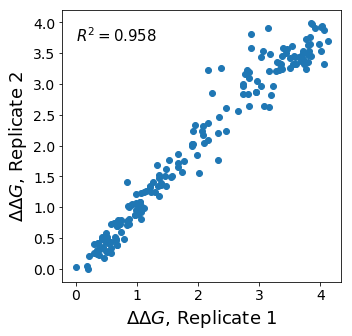

In [31]:
fig = plt.figure(figsize=(5,5))

ax = fig.add_subplot(111)
ax.scatter(GR_WT_1_fits['ddG'], GR_WT_2_fits['ddG'])

r,p = stats.pearsonr(GR_WT_1_fits['ddG'], GR_WT_2_fits['ddG'])

ax.text(0,3.7,'$R^2=$%.3f' % r**2, fontsize=15)
ax.tick_params(labelsize=14)

ax.set_xlabel('$\Delta\Delta G$, Replicate 1', fontsize=18)
ax.set_ylabel('$\Delta\Delta G$, Replicate 2', fontsize=18)

### Construct PSAM

In [ ]:
# first with MITOMI motif sequences

In [149]:
temp = np.mean([np.array(GR_WT_1_fits.loc[80:124,'ddG']),
                 np.array(GR_WT_2_fits.loc[80:124,'ddG'])], axis=0) - np.mean([GR_WT_1_fits.loc[79,'ddG'],
                                                                               GR_WT_2_fits.loc[79,'ddG']])

In [150]:
GR_ddG_MITOMI = [[temp[0], temp[1], 0, temp[2]],
          [temp[3], temp[4], 0, temp[5]],
          [temp[6], temp[7], 0, temp[8]],
          [0, temp[9], temp[10], temp[11]],
          [temp[12], 0, temp[13], temp[14]],
          [0, temp[15], temp[16], temp[17]],
          [temp[18], temp[19], temp[20], 0],
          [temp[21], temp[22], 0, temp[23]],
          [0, temp[24], temp[25], temp[26]],
          [temp[27], temp[28], temp[29], 0],
          [temp[30], temp[31], 0, temp[32]],
          [temp[33], temp[34], temp[35], 0],
          [temp[36], 0, temp[37], temp[38]],
          [temp[39], 0, temp[40], temp[41]],
          [temp[42], 0, temp[43], temp[44]]]

In [ ]:
# next with ChIP motif sequences

In [152]:
temp = np.mean([np.array(GR_WT_1_fits.loc[1:49,'ddG']),
                np.array(GR_WT_2_fits.loc[1:49,'ddG'])], axis=0) - np.mean([GR_WT_1_fits.loc[0,'ddG'],
                                                                            GR_WT_2_fits.loc[0,'ddG']])

In [153]:
GR_ddG_ChIP = [[temp[0], 0, temp[1], temp[2]],
          [0, temp[3], temp[4], temp[5]],
          [temp[6], temp[7], 0, temp[8]],
          [0, temp[9], temp[10], temp[11]],
          [0, temp[12], temp[13], temp[14]],
          [temp[15], 0, temp[16], temp[17]],
          [0, temp[18], temp[19], temp[20]],
          [temp[21], temp[22], temp[23], 0],
          [temp[24], temp[25], temp[26], 0],
          [temp[27], 0, temp[28], temp[29]],
          [temp[30], temp[31], temp[32], 0],
          [temp[33], temp[34], 0, temp[35]],
          [temp[36], temp[37], temp[38], 0],
          [temp[39], temp[40], temp[41], 0],
          [temp[42], 0, temp[43], temp[44]],
          [temp[45], temp[46], temp[47], 0]]

In [174]:
len(GR_PSAM)

15

In [ ]:
# combine them

In [187]:
GR_ddG_combined = (np.array(GR_ddG_ChIP[1:]) + np.array(GR_ddG_MITOMI))/2

In [188]:
R=1.9872036e-3
T=295
GR_PSAM = []

for base in GR_ddG_combined:
    temp = base-np.min(base)
    GR_PSAM.append([np.exp(-x/(R*T)) for x in temp])

In [189]:
GR_PSAM

[[1.0, 0.8974335169087382, 0.820557430856223, 0.6671497224363918],
 [0.3847327846395602, 0.1931913155874595, 1.0, 0.2913496709715903],
 [0.9347039887492387, 0.7665537368413462, 0.7789302802129148, 1.0],
 [1.0, 0.10194806200027236, 0.14116174261825182, 0.0997504894332275],
 [0.04701346834049215, 1.0, 0.019491306799740094, 0.0802002818240821],
 [1.0, 0.15499546928548913, 0.6320645926591755, 0.2880187091336975],
 [0.6189135328243149, 1.0, 0.43497408994221765, 0.7426852590396471],
 [0.8436896757457115, 1.0, 0.5746208167238983, 0.9968956962653354],
 [0.8826498538927376, 0.8372844836561458, 0.8396261183047686, 1.0],
 [0.3638458522372175, 0.9360815177871751, 0.10988641276487936, 1.0],
 [0.08572154058116886, 0.06864095066836838, 1.0, 0.04861798562587484],
 [0.17616403693818353, 0.28513167598149697, 0.18700206395020466, 1.0],
 [0.7727133878772953, 0.9609526746276463, 0.489289726783025, 1.0],
 [0.2872816391473612, 1.0, 0.18048341558334374, 0.35447662614159386],
 [0.5598293423415454, 0.5440153259

In [186]:
outfile = open('../GR_PSAM_Pollymeasurements.csv', 'w')

outfile.write(','+','.join([str(x) for x in range(1,16)])+'\n')

outfile.write('A,'+','.join([str(x[0]) for x in GR_PSAM])+'\n')

outfile.write('C,'+','.join([str(x[1]) for x in GR_PSAM])+'\n')

outfile.write('G,'+','.join([str(x[2]) for x in GR_PSAM])+'\n')

outfile.write('T,'+','.join([str(x[3]) for x in GR_PSAM])+'\n')


outfile.close()

### Compare to Polly's analyses

In [31]:
polly_gr_fits = pd.read_excel('../DataFromBothExperiments.xlsx')

In [36]:
merged_df = polly_gr_fits.rename(columns={'Oligo #':'Oligo'})[['Oligo','KaN_1']].merge(GR_WT_1_fits)

In [43]:
ref_Ka = np.max(merged_df['KaN_1'])
merged_df['ddG_polly'] = merged_df['KaN_1'].apply(lambda x: calculate_ddG(ref_Ka,x))

Text(0, 0.5, '$\\Delta\\Delta G$, Replicate 2')

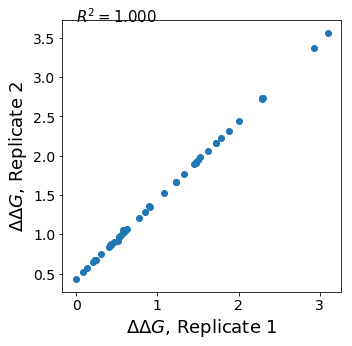

In [44]:
fig = plt.figure(figsize=(5,5))

ax = fig.add_subplot(111)
ax.scatter(merged_df['ddG_polly'], merged_df['ddG'])

r,p = stats.pearsonr(merged_df['ddG_polly'], merged_df['ddG'])

ax.text(0,3.7,'$R^2=$%.3f' % r**2, fontsize=15)
ax.tick_params(labelsize=14)

ax.set_xlabel('$\Delta\Delta G$, Replicate 1', fontsize=18)
ax.set_ylabel('$\Delta\Delta G$, Replicate 2', fontsize=18)